## Biodiversity Intactness Index change in Phoenix, AZ

Author : Joaquin Sandoval 

Link to GitHub repository: https://github.com/sandovaljoaquin/biodiversity-intactness-index-change

## About

The purpose of this notebook is to explore the impacts of urban expansion in the Pheonix area on biodiversity. 

### Highlights: 

- Retrieving data from Microsoft Planetary Computer SpatioTemporal Asset Catalog (STAC). 
- Clipping data to the boundary of Houston subdivison 
- Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in  2017 and 2020. 
- Calculating the area with BII>=0.75 in 2017 that was lost by 2020.
- Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.


### About the data: 

[1] Biodiversity Intactness Index (BII) Time Series collection from the Microsoft Planetary Computer STAC catalog. Contains raster data from 2017-2020. 

[2] County subdivision shapefiles for Arizona. County subdivisions are the primary divisions of counties and equivalent entities for the reporting of Census Bureau data.

### References

[1] 
Microsoft Planetary Computer. (2025). IO biodiversity dataset. https://planetarycomputer.microsoft.com/dataset/io-biodiversity

[2] 
U.S. Census Bureau. (2025). *TIGER/Line shapefile – Current state: Arizona, county subdivision*. https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision 

Import necessary libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box
import contextily as ctx

import pystac_client
import planetary_computer

from IPython.display import Image 

Import Arizona county subdivision shapefiles and filter for Pheonix.

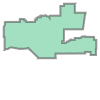

In [2]:
# Import shapefile

fp = os.path.join('data', 'tl_2025_04_cousub', 'tl_2025_04_cousub.shp')
counties = gpd.read_file(fp)

counties.columns = (counties.columns                # Clean to lower snake case 
                    .str.lower()             
                    .str.replace(' ' , '_'))

pheonix = counties[counties['name'] == 'Phoenix']   # Subset to Pheonix subdivison
pheonix_polygon = pheonix.geometry.iloc[0]
pheonix_polygon                                     # Verify shape is correct 

## Retrieving data from Microsoft Planetary Computer SpatioTemporal Asset Catalog (STAC). 

Create a bounding box for catalog search. 

In [3]:
# Bounding‑box coordinates for catalog search (minx, miny, maxx, maxy)

bbox_coords = [-112.826843, 32.974108, -111.184387, 33.863574]
bbox_coords

[-112.826843, 32.974108, -111.184387, 33.863574]

In [4]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# View collection
io_collection = catalog.get_child('io-biodiversity')
io_collection

<CollectionClient id=io-biodiversity>

Search the MPC catalog for `io-biodiversity` collection with bounding box coordinates.

In [5]:
# Search MPC catalog 
search = catalog.search(collections= ['io-biodiversity'], 
                        bbox = bbox_coords)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


4 items are returned. Each item is a raster layer for a respective year (2017-2020). Select a year by subset bracketing. [0] is equal to 2017. [1] is equal to 2018. [2] is equal to 2019. [3] is equal to 2020.  Load raster data as a xarray.DataArray using `rioxr.open_rasterio()`

In [6]:
# Select unique search item for 2017
bii_2017 = items[0]
# Loading 2017 raster data using open_rasterio()
bii_2017 = rioxr.open_rasterio(bii_2017.assets['data'].href)
bii_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# Select unique search item for 2020
bii_2020 = items[3]
# Loading 2020 raster data using open_rasterio()
bii_2020 = rioxr.open_rasterio(bii_2020.assets['data'].href)
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Now we are working with two rasters and a shapefile. Both have their own CRS, we need to ensure they are the same.

In [8]:
 #Convert the pheonix shapefile CRS to the bii raster CRS and verify update 

pheonix_match = pheonix.to_crs(bii_2017.rio.crs)
assert pheonix_match.crs == bii_2017.rio.crs 

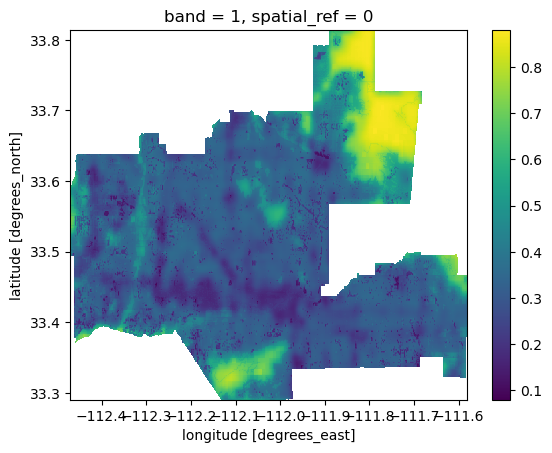

In [9]:
# Clip large 2017 raster to detailed geometry in two steps 

bii_2017_clip = (bii_2017.rio.clip_box(*pheonix_match.total_bounds)
                 .rio.clip(pheonix_match.geometry)
                 )

# Examine results
bii_2017_clip.plot()   

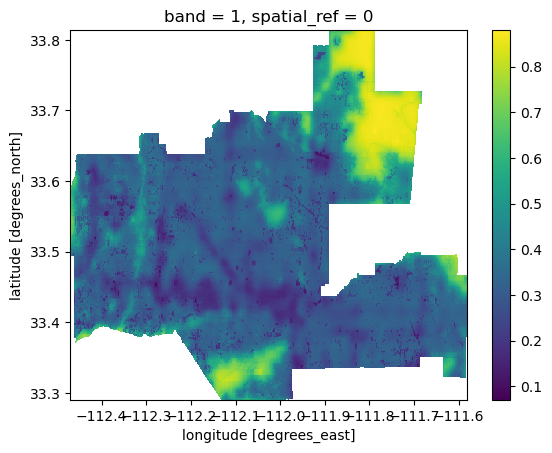

In [10]:
# Clip large 2020 raster to detailed geometry in two steps 

bii_2020_clip = (bii_2020.rio.clip_box(*pheonix_match.total_bounds)
                 .rio.clip(pheonix_match.geometry)
                 )

# Examine results
bii_2020_clip.plot()  

## Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in  2017 and 2020. 

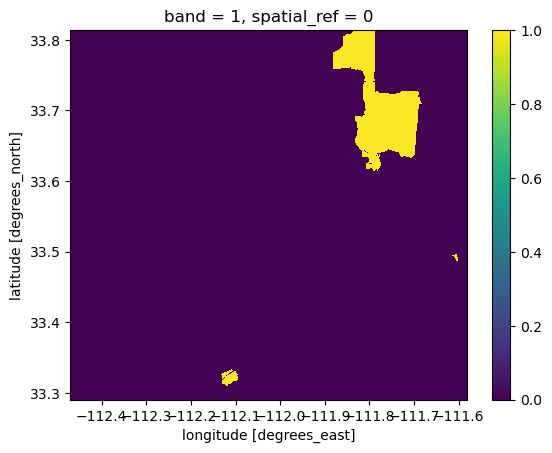

In [11]:
# Returns a True if each cell is greater than .75
bii_2017_high = bii_2017_clip > 0.75
# Plot to visualize 
bii_2017_high.plot()

This is a visualization of the areas in Pheonix that have values of BII greater than or equal to .75 in 2017. We need to do the same for 2020.  

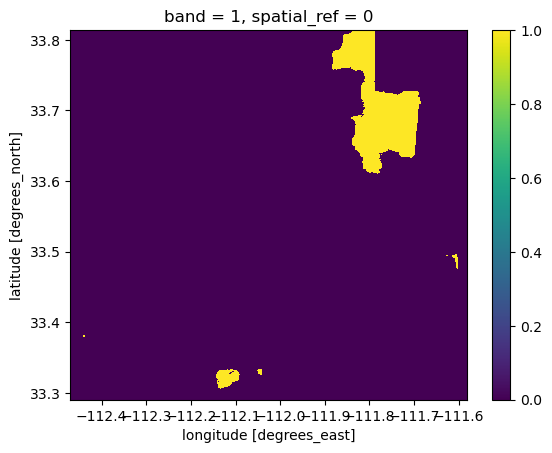

In [12]:
bii_2020_high = bii_2020_clip > 0.75
bii_2020_high.plot()

Very subtle, but there are differences in the yellow shaded regions between the two years. Visualize in the next code. 

## Calculating the area with BII>=0.75 in 2017 that was lost by 2020.

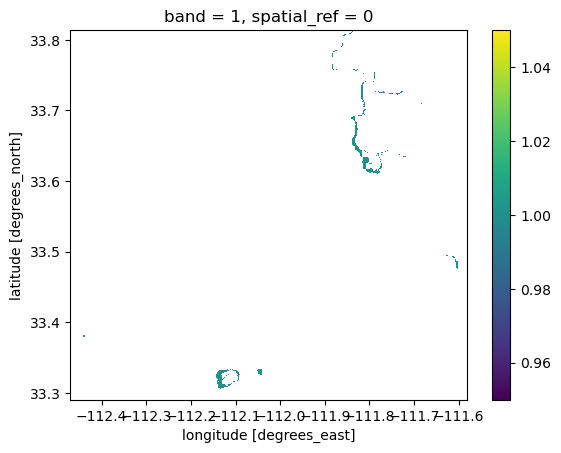

In [13]:
# Calculating the difference in high bii between the two years 
difference = bii_2017_high ^ bii_2020_high
# Creating a mask for only difference values in raster
difference = difference.where(difference, other=np.nan)
difference.plot()

These values  represent areas that had BII>=0.75 in 2017 but not in 2020. 

## Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.
Plot the 2020 Biodiversity Intactness Index (BII) Phoenix Subdivision and area with BII greater than 0.75 lost from 2017. 

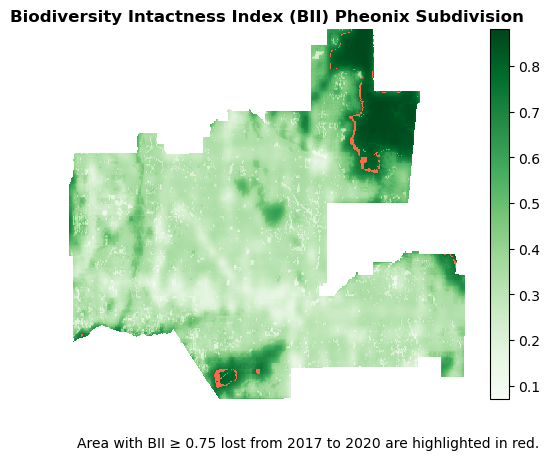

In [14]:
# Plot
fig, ax = plt.subplots()  

bii_2020_clip.plot(
    ax=ax, 
    cmap = 'Greens')

difference.plot(ax = ax, 
                  cmap = 'Reds',
                  add_colorbar = False)

ax.set_title("Biodiversity Intactness Index (BII) Pheonix Subdivision", 
             fontweight = "bold")  
fig.text(0.5, 0.01,
         "Area with BII ≥ 0.75 lost from 2017 to 2020 are highlighted in red.",
         ha='center')

# Remove axes labels
ax.axis("off")
plt.show()